## Baselines

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.metrics import auc, f1_score, roc_curve

from luminar.mongo import MongoDataset, MongoFindDataset

load_dotenv("../.env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
def calculcate_f1_for_metrics(dataset: MongoDataset):
    metrics = [
        (
            x["metrics"][0]["llr"],
            x["metrics"][0]["fast_detect_gpt"],
            int(x["type"] != "source"),
        )
        for x in dataset
        if "metrics" in x
    ]
    llr, fdg, labels = zip(*metrics)

    fpr, tpr, _ = roc_curve(labels, llr)
    llr_auroc = auc(fpr, tpr)

    fpr, tpr, _ = roc_curve(labels, fdg)
    fdg_auroc = auc(fpr, tpr)

    llr = np.array(llr)
    fdg = np.array(fdg)
    labels = np.array(labels)

    llr_human_mean, llr_ai_mean = np.mean(llr[labels == 1]), np.mean(llr[labels == 0])
    llr_threshold = (llr_human_mean + llr_ai_mean) / 2
    llr_f1 = max(
        f1_score(labels, llr > llr_threshold), f1_score(labels, llr < llr_threshold)
    )

    fdg_human_mean, fdg_ai_mean = np.mean(fdg[labels == 1]), np.mean(fdg[labels == 0])
    fdg_threshold = (fdg_human_mean + fdg_ai_mean) / 2
    fdg_f1 = max(
        f1_score(labels, fdg > fdg_threshold), f1_score(labels, fdg < fdg_threshold)
    )

    return (
        llr_auroc,
        fdg_auroc,
        llr_f1,
        fdg_f1,
        {
            "llr": llr,
            "fdg": fdg,
            "labels": labels,
            "llr_boundaries": (llr_human_mean, llr_threshold, llr_ai_mean),
            "fdg_boundaries": (fdg_human_mean, fdg_threshold, fdg_ai_mean),
        },
    )

In [13]:
domains = {
    "Web Blogs": {"domain": "blog_authorship_corpus"},
    "Student Essays": {"domain": "student_essays"},
    "CNN-DailyMail": {"domain": "cnn_news"},
    "European Court of Human Rights": {"domain": "euro_court_cases"},
    "House of Commons": {"domain": "house_of_commons"},
    "arXiv Papers": {"domain": "arxiv_papers"},
    "Gutenberg": {"domain": "gutenberg", "lang": "en-EN"},
    "Bundestag$_{de}$": {"domain": "bundestag"},
    "Spiegel$_{de}$": {"domain": "spiegel_articles"},
}

In [14]:
metric_datasets = {
    name: MongoFindDataset(
        {
            "model.name": "gpt2",
            "document.agent": {"$in": [None, "gpt-4o-mini"]},
            "document.domain": kwargs["domain"],
            "document.type": {"$in": ["source", "fulltext"]},
        },
        projection={"metrics": 1, "type": "$document.type"},
        mongo_db_connection=os.getenv("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_prismai",
        # update_cache=True,
    ).load(verbose=False)
    for name, kwargs in domains.items()
}

In [15]:
results = []
metrics = {}
for domain, dataset in metric_datasets.items():
    llr_auroc, fdg_auroc, llr_f1, fdg_f1, data = calculcate_f1_for_metrics(dataset)
    results.append(
        {
            "domain": domain,
            "llr_auroc": llr_auroc,
            "llr_f1": llr_f1,
            "fdg_auroc": fdg_auroc,
            "fdg_f1": fdg_f1,
        }
    )
    metrics[domain] = data


metric_df = (
    pd.DataFrame(results)
    .set_index("domain")
    .sort_index(key=lambda x: list(map(list(domains.keys()).index, x)))
)
# print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

,llr_auroc,llr_f1,fdg_auroc,fdg_f1
domain,,,,
Web Blogs,0.469606,0.492636,0.368987,0.587284
Student Essays,0.846468,0.778818,0.925428,0.832519
CNN-DailyMail,0.941684,0.875727,0.971519,0.914773
European Court of Human Rights,0.915525,0.850660,0.820074,0.744000
House of Commons,0.855789,0.829063,0.831460,0.808852
arXiv Papers,0.965482,0.937151,0.865916,0.847051
Gutenberg,0.858639,0.766686,0.907390,0.874029
Bundestag$_{de}$,0.845536,0.787262,0.799356,0.748005
Spiegel$_{de}$,0.867969,0.803719,0.781628,0.700546


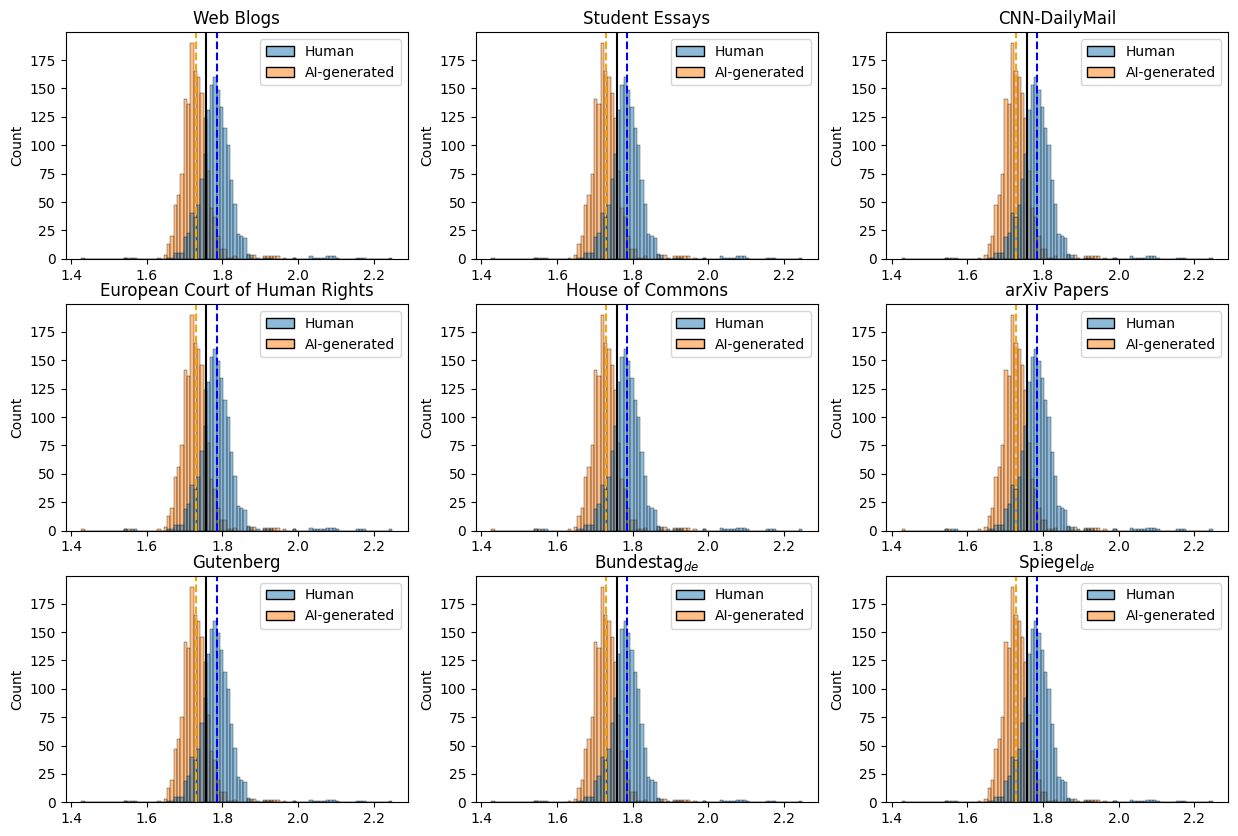

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, (domain, datat) in zip(axes.flat, metric_datasets.items()):
    sns.histplot(
        x=data["llr"], hue=["Human" if x else "AI-generated" for x in data["labels"]], ax=ax
    )
    human_mean, threshold, ai_mean = data["llr_boundaries"]
    ax.axvline(human_mean, color="blue", linestyle="--")
    ax.axvline(threshold, color="black", linestyle="-")
    ax.axvline(ai_mean, color="orange", linestyle="--")
    ax.set_title(domain)
plt.show()

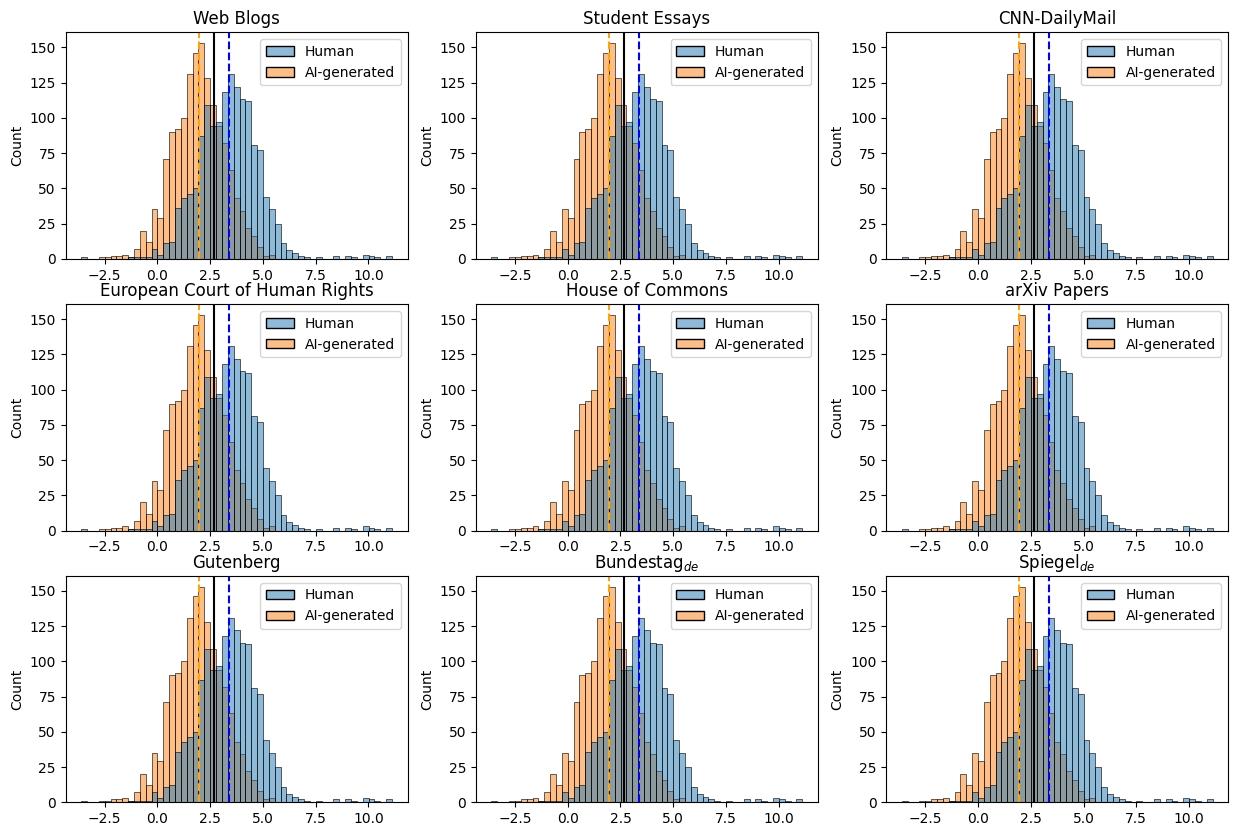

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, (domain, datat) in zip(axes.flat, metric_datasets.items()):
    sns.histplot(
        x=data["fdg"], hue=["Human" if x else "AI-generated" for x in data["labels"]], ax=ax
    )
    human_mean, threshold, ai_mean = data["fdg_boundaries"]
    ax.axvline(human_mean, color="blue", linestyle="--")
    ax.axvline(threshold, color="black", linestyle="-")
    ax.axvline(ai_mean, color="orange", linestyle="--")
    ax.set_title(domain)
plt.show()

In [18]:
metric_datasets = {
    name: MongoFindDataset(
        {
            "model.name": "meta-llama/Llama-3.2-1B",
            "document.agent": {"$in": [None, "gpt-4o-mini"]},
            "document.domain": kwargs["domain"],
            "document.type": {"$in": ["source", "fulltext"]},
        },
        projection={"metrics": 1, "type": "$document.type"},
        mongo_db_connection=os.getenv("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_prismai",
        # update_cache=True,
    ).load(verbose=False)
    for name, kwargs in domains.items()
    if name not in  {"Gutenberg", "Bundestag$_{de}$"}
}

In [19]:
results = []
metrics = {}
for domain, dataset in metric_datasets.items():
    llr_auroc, fdg_auroc, llr_f1, fdg_f1, data = calculcate_f1_for_metrics(dataset)
    results.append(
        {
            "domain": domain,
            "llr_auroc": llr_auroc,
            "llr_f1": llr_f1,
            "fdg_auroc": fdg_auroc,
            "fdg_f1": fdg_f1,
        }
    )
    metrics[domain] = data


metric_df = (
    pd.DataFrame(results)
    .set_index("domain")
    .sort_index(key=lambda x: list(map(list(domains.keys()).index, x)))
)
# print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

,llr_auroc,llr_f1,fdg_auroc,fdg_f1
domain,,,,
Web Blogs,0.803556,0.678439,0.886145,0.766332
Student Essays,0.979607,0.931034,0.963151,0.892473
CNN-DailyMail,0.975793,0.935227,0.949988,0.872611
European Court of Human Rights,0.836135,0.752630,0.611794,0.557818
House of Commons,0.839533,0.826546,0.894093,0.821958
arXiv Papers,0.831391,0.803431,0.877525,0.811355
Spiegel$_{de}$,0.975335,0.929685,0.971988,0.902319


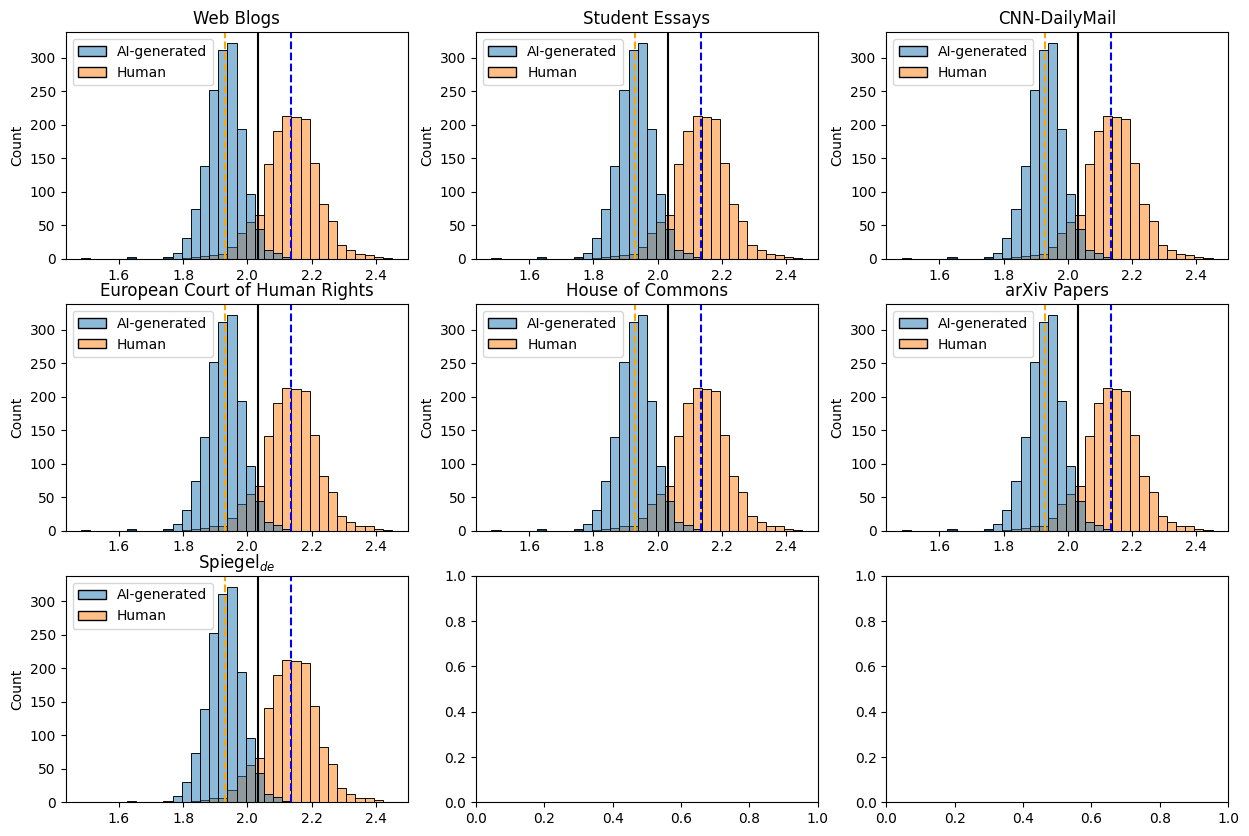

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, (domain, datat) in zip(axes.flat, metric_datasets.items()):
    sns.histplot(
        x=data["llr"], hue=["Human" if x else "AI-generated" for x in data["labels"]], ax=ax
    )
    human_mean, threshold, ai_mean = data["llr_boundaries"]
    ax.axvline(human_mean, color="blue", linestyle="--")
    ax.axvline(threshold, color="black", linestyle="-")
    ax.axvline(ai_mean, color="orange", linestyle="--")
    ax.set_title(domain)
plt.show()

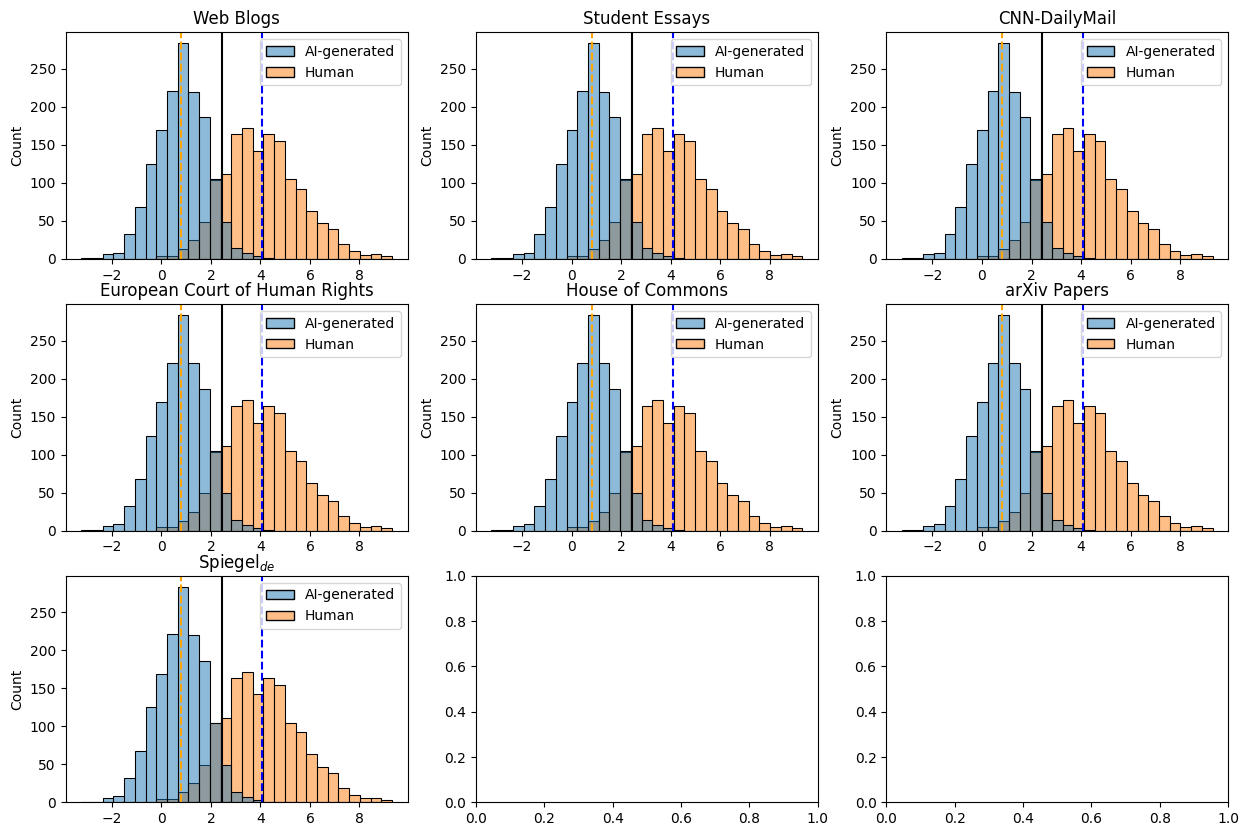

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, (domain, datat) in zip(axes.flat, metric_datasets.items()):
    sns.histplot(
        x=data["fdg"], hue=["Human" if x else "AI-generated" for x in data["labels"]], ax=ax
    )
    human_mean, threshold, ai_mean = data["fdg_boundaries"]
    ax.axvline(human_mean, color="blue", linestyle="--")
    ax.axvline(threshold, color="black", linestyle="-")
    ax.axvline(ai_mean, color="orange", linestyle="--")
    ax.set_title(domain)
plt.show()